# Column Generation: Physician Scheduling

#### Libraries

In [1]:
from gurobipy import *
import gurobipy as gu
import pandas as pd
import numpy as np
import os
import time
import random
import plotly.io as pio

#### Define Sets and create Pandas DataFrame


In [2]:
# Set of indices
I, T, K= [1, 2, 3], [1, 2, 3, 4, 5, 6, 7], [1, 2, 3]

# Create Dataframes
data = pd.DataFrame({
    'I': I + [np.nan] * (max(len(I), len(T), len(K)) - len(I)),
    'T': T + [np.nan] * (max(len(I), len(T), len(K)) - len(T)),
    'K': K + [np.nan] * (max(len(I), len(T), len(K)) - len(K))
})

#### Define function to generate the individual $\alpha_{it}$'s



In [3]:
def gen_alpha(seed):
    random.seed(seed)
    alpha = {(i, t): round(random.random(), 3) for i in I for t in T}
    return alpha

#### Set demand and parameter

In [86]:
# Demand Dict
demand_dict = {(1, 1): 2, (1, 2): 1, (1, 3): 0, (2, 1): 1, (2, 2): 2, (2, 3): 0, (3, 1): 1, (3, 2): 1, (3, 3): 1,
               (4, 1): 1, (4, 2): 2, (4, 3): 0, (5, 1): 2, (5, 2): 0, (5, 3): 1, (6, 1): 1, (6, 2): 1, (6, 3): 1,
               (7, 1): 0, (7, 2): 3, (7, 3): 0}

# Parameter
time_Limit = 3600
max_itr = 10
seed = 123
output_len = 98
mue = 1e-4
threshold = 1e-6

## Build compact model

In [18]:
class Problem:
    def __init__(self, dfData, DemandDF, alpha):
        self.I = dfData['I'].dropna().astype(int).unique().tolist()
        self.T = dfData['T'].dropna().astype(int).unique().tolist()
        self.K = dfData['K'].dropna().astype(int).unique().tolist()
        self.demand = DemandDF
        self.Max = 5
        self.Min = 2
        self.M = 1e6
        self.alpha = alpha
        self.model = gu.Model("Problems")

    def buildModel(self):
        self.t0 = time.time()
        self.generateVariables()
        self.generateConstraints()
        self.generateObjective()
        self.model.update()

    def generateVariables(self):
        self.slack = self.model.addVars(self.T, self.K, vtype=gu.GRB.CONTINUOUS, lb=0, name='slack')
        self.motivation = self.model.addVars(self.I, self.T, self.K, vtype=gu.GRB.CONTINUOUS, lb=0, ub=1, name='motivation')
        self.x = self.model.addVars(self.I, self.T, self.K, vtype=gu.GRB.BINARY, name='x')
        self.y = self.model.addVars(self.I, self.T, vtype=gu.GRB.BINARY, name='y')
        self.mood = self.model.addVars(self.I, self.T, vtype=gu.GRB.CONTINUOUS, lb=0, name='mood')

    def generateConstraints(self):
        for t in self.T:
            for s in self.K:
                self.model.addConstr(
                    gu.quicksum(self.motivation[i, t, s,] for i in self.I) + self.slack[t, s] >= self.demand[t, s])
        for i in self.I:
            for t in self.T:
                self.model.addLConstr(self.mood[i, t] == 1 - self.alpha[i, t])
                self.model.addLConstr(quicksum(self.x[i, t, s] for s in self.K) == self.y[i, t])
                self.model.addLConstr(gu.quicksum(self.x[i, t, s] for s in self.K) <= 1)
                for s in self.K:
                    self.model.addLConstr(self.motivation[i, t, s] >= self.mood[i, t] - self.M * (1 - self.x[i, t, s]))
                    self.model.addLConstr(self.motivation[i, t, s] <= self.mood[i, t] + self.M * (1 - self.x[i, t, s]))
                    self.model.addLConstr(self.motivation[i, t, s] <= self.x[i, t, s])
            for t in range(1, len(self.T) - self.Max + 1):
                self.model.addLConstr(gu.quicksum(self.y[i, u] for u in range(t, t + 1 + self.Max)) <= self.Max)
            self.model.addLConstr(gu.quicksum(self.y[i, t] for t in self.T) >= self.Min)

    def generateObjective(self):
        self.model.setObjective(gu.quicksum(self.slack[t, s] for t in self.T for s in self.K), sense=gu.GRB.MINIMIZE)

    def solveModel(self, timeLimit):
        try:
            self.model.setParam('TimeLimit', timeLimit)
            self.model.Params.IntegralityFocus = 1
            self.model.Params.FeasibilityTol = 1e-9
            self.model.Params.BarConvTol = 0.0
            self.model.Params.MIPGap = 1e-2
            self.model.optimize()
            self.model.Params.LogToConsole = 0
            self.model.Params.LogFile = "./log_file_compact.log"
            self.t1 = time.time()
        except gu.GurobiError as e:
            print('Error code ' + str(e.errno) + ': ' + str(e))

    def getTime(self):
        self.time_total = self.t1 - self.t0
        return self.time_total

    def get_final_values(self):
        dict = self.model.getAttr("X", self.x)
        liste = list(dict.values())
        final = [0.0 if x == -0.0 else x for x in liste]
        return final

    def get_final_values_dict(self):
        return self.model.getAttr("X", self.x)

#### Build and solve compact model

In [19]:
problem = Problem(data, demand_dict, gen_alpha(seed))
problem.buildModel()
problem.solveModel(time_Limit)

Set parameter TimeLimit to value 3600
Set parameter IntegralityFocus to value 1
Set parameter FeasibilityTol to value 1e-09
Set parameter BarConvTol to value 0
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 282 rows, 189 columns and 813 nonzeros
Model fingerprint: 0x1a60771f
Variable types: 105 continuous, 84 integer (84 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-02, 1e+06]
Found heuristic solution: objective 4.200000e+10
Presolve removed 243 rows and 120 columns
Presolve time: 0.00s
Presolved: 39 rows, 69 columns, 159 nonzeros
Found heuristic solution: objective 16.0199991
Variable types: 12 continuous, 57 integer (57 binary)

Root relaxation: objective 7.899998e+00, 41 iterations, 0.00 seconds (0.00 work 

#### Calculate objective function value and store model runtime

In [20]:
obj_val_problem = round(problem.model.objval, 3)
time_problem = round(problem.getTime(), 4)
vals_prob = problem.get_final_values()

## Column Generation

#### Column generation prerequisites

In [21]:
# Prerequisites
modelImprovable = True
t0 = time.time()
itr = 0
last_itr = 0

# Create empty results lists
objValHistSP = []
timeHist = []
objValHistRMP = []
avg_rc_hist = []
avg_sp_time = []
gap_rc_hist = []

Iter_schedules = {}
for index in I:
    Iter_schedules[f"Nurse_{index}"] = []

### Define Master Problem

Used to cordinate the individual subproblems

In [95]:
class MasterProblem:
    def __init__(self, df, Demand, max_iteration, current_iteration, last ,nr, delta, zeta, decay, threshold):
        self.iteration = current_iteration
        self.max_iteration = max_iteration
        self.nurses = df['I'].dropna().astype(int).unique().tolist()
        self.days = df['T'].dropna().astype(int).unique().tolist()
        self.shifts = df['K'].dropna().astype(int).unique().tolist()
        self._current_iteration = current_iteration
        self.roster = [i for i in range(1, self.max_iteration + 2)]
        self.rosterinitial = [i for i in range(1, 2)]
        self.demand = Demand
        self.model = gu.Model("MasterProblem")
        self.cons_demand = {}
        self.newvar = {}
        self.last_itr = last
        self.max_itr = max_iteration
        self.cons_lmbda = {}
        self.output_len = nr
        self.initial_delta = delta
        self.initial_zeta = zeta
        self.decay_rate = decay
        self.zetal = threshold

    def buildModel(self):
        self.generateVariables()
        self.generateParameter()
        self.generateConstraints()
        self.model.update()
        self.generateObjective()
        self.model.update()

    def generateVariables(self):
        self.slack = self.model.addVars(self.days, self.shifts, vtype=gu.GRB.CONTINUOUS, lb=0, name='slack')
        self.motivation_i = self.model.addVars(self.nurses, self.days, self.shifts, self.roster,
                                               vtype=gu.GRB.CONTINUOUS, lb=0, ub=1, name='motivation_i')
        self.lmbda = self.model.addVars(self.nurses, self.roster, vtype=gu.GRB.BINARY, lb=0, name='lmbda')
        self.theta_plus = self.model.addVars(self.days, self.shifts, vtype=gu.GRB.CONTINUOUS, lb = 0, name = "theta_plus")
        self.theta_minus = self.model.addVars(self.days, self.shifts, vtype=gu.GRB.CONTINUOUS, lb = 0, name = "theta_minus")

    def generateParameter(self):
        self.delta_plus, self.delta_minus = {(t, s): self.initial_delta for t in self.days for s in self.shifts}, {(t, s): self.initial_delta for t in self.days for s in self.shifts}
        self.zeta_plus, self.zeta_minus = {(t, s): self.initial_zeta for t in self.days for s in self.shifts}, {(t, s): self.initial_zeta for t in self.days for s in self.shifts}
        self.model.update()

    def generateConstraints(self):
        for i in self.nurses:
            self.cons_lmbda[i] = self.model.addLConstr(1 == gu.quicksum(self.lmbda[i, r] for r in self.rosterinitial), name = "lmb("+str(i)+")")
        for t in self.days:
            for s in self.shifts:
                self.cons_demand[t, s] = self.model.addConstr(
                    gu.quicksum(self.motivation_i[i, t, s, r]*self.lmbda[i, r] for i in self.nurses for r in self.rosterinitial) +
                    self.slack[t, s] + self.theta_plus[t, s] - self.theta_minus[t,s ] >= self.demand[t, s], "demand("+str(t)+","+str(s)+")")
        for t in self.days:
            for s in self.shifts:
                self.model.addConstr(self.theta_plus[t, s] <= self.zeta_plus[t, s])
                self.model.addConstr(self.theta_minus[t, s] <= self.zeta_minus[t, s])
        return self.cons_lmbda, self.cons_demand

    def generateObjective(self):
        self.model.setObjective(gu.quicksum(self.slack[t, s] for t in self.days for s in self.shifts) +
                                gu.quicksum(self.delta_plus[t, s] * self.theta_plus[t, s] for t in self.days for s in self.shifts) -
                                gu.quicksum(self.delta_minus[t, s] * self.theta_minus[t, s] for t in self.days for s in self.shifts),
                                sense=gu.GRB.MINIMIZE)

    def getDuals_i(self):
        Pi_cons_lmbda = self.model.getAttr("Pi", self.cons_lmbda)
        return Pi_cons_lmbda

    def getDuals_ts(self):
        Pi_cons_demand = self.model.getAttr("QCPi", self.cons_demand)
        return Pi_cons_demand

    def updateModel(self):
        self.model.update()

    def setStartSolution(self):
        for i in self.nurses:
            for t in self.days:
                for s in self.shifts:
                    self.model.addConstr(0 == self.motivation_i[i ,t, s, 1])

    def addColumn(self, index, itr, schedule):
        self.nurseIndex = index
        self.rosterIndex = itr + 1
        for t in self.days:
            for s in self.shifts:
                qexpr = self.model.getQCRow(self.cons_demand[t, s])
                qexpr.add(schedule[self.nurseIndex, t, s, self.rosterIndex] * self.lmbda[self.nurseIndex, self.rosterIndex], 1)
                rhs = self.cons_demand[t, s].getAttr('QCRHS')
                sense = self.cons_demand[t, s].getAttr('QCSense')
                name = self.cons_demand[t, s].getAttr('QCName')
                newcon = self.model.addQConstr(qexpr, sense, rhs, name)
                self.model.remove(self.cons_demand[t, s])
                self.cons_demand[t, s] = newcon
        self.model.update()

    def addLambda(self, index, itr):
        self.nurseIndex = index
        self.rosterIndex = itr + 1
        self.newlmbcoef = 1.0
        current_lmb_cons = self.cons_lmbda[self.nurseIndex]
        expr = self.model.getRow(current_lmb_cons)
        new_lmbcoef = self.newlmbcoef
        expr.add(self.lmbda[self.nurseIndex, self.rosterIndex], new_lmbcoef)
        rhs_lmb = current_lmb_cons.getAttr('RHS')
        sense_lmb = current_lmb_cons.getAttr('Sense')
        name_lmb = current_lmb_cons.getAttr('ConstrName')
        newconlmb = self.model.addLConstr(expr, sense_lmb, rhs_lmb, name_lmb)
        self.model.remove(current_lmb_cons)
        self.cons_lmbda[self.nurseIndex] = newconlmb

    def finalSolve(self, timeLimit):
        try:
            self.model.setParam('TimeLimit', timeLimit)
            self.model.Params.IntegralityFocus = 1
            self.model.Params.FeasibilityTol = 1e-9
            self.model.Params.BarConvTol = 0.0
            self.model.Params.MIPGap = 1e-2
            self.model.Params.OutputFlag = 1
            self.model.setAttr("vType", self.lmbda, gu.GRB.BINARY)
            self.model.update()
            self.model.optimize()
            if self.model.status == GRB.OPTIMAL:
                print("*" * (self.output_len + 2))
                print("*{:^{output_len}}*".format("***** Optimal solution found *****", output_len=self.output_len))
                print("*{:^{output_len}}*".format("", output_len=self.output_len))
            else:
                print("*" * (self.output_len + 2))
                print("*{:^{output_len}}*".format("***** No optimal solution found *****", output_len=self.output_len))
                print("*{:^{output_len}}*".format("", output_len=self.output_len))
        except gu.GurobiError as e:
            print('Error code ' + str(e.errno) + ': ' + str(e))

    def updateDelta(self, duals):
        for t in self.days:
            for s in self.shifts:
                self.delta_plus[t, s] = duals[(t, s)]
                self.delta_minus[t, s] = duals[(t, s)]

        self.model.update()

    def updateZetaPlus(self):
        for t in self.days:
            for s in self.shifts:
                if self.zeta_plus[t, s] > self.zetal:
                    self.zeta_plus[t, s] *= self.decay_rate
                else:
                    break

        self.model.update()

    def updateZetaMinus(self):
        for t in self.days:
            for s in self.shifts:
                if self.zeta_minus[t, s] > self.zetal:
                    self.zeta_minus[t, s] *= self.decay_rate
                else:
                    break

        self.model.update()

    def solveModel(self, timeLimit):
        try:
            self.model.setParam('TimeLimit', timeLimit)
            self.model.Params.QCPDual = 1
            self.model.Params.OutputFlag = 0
            self.model.Params.IntegralityFocus = 1
            self.model.Params.FeasibilityTol = 1e-9
            self.model.Params.BarConvTol = 0.0
            self.model.Params.MIPGap = 1e-2
            self.model.optimize()
        except gu.GurobiError as e:
            print('Error code ' + str(e.errno) + ': ' + str(e))

    def solveRelaxModel(self):
        try:
            self.model.Params.QCPDual = 1
            for v in self.model.getVars():
                v.setAttr('vtype', 'C')
            self.model.optimize()
        except gu.GurobiError as e:
            print('Error code ' + str(e.errno) + ': ' + str(e))

### Define Subproblems


In [66]:
class Subproblem:
    def __init__(self, duals_i, duals_ts, df, i, BigM, iteration, alpha):
        itr = iteration + 1
        self.days = df['T'].dropna().astype(int).unique().tolist()
        self.shifts = df['K'].dropna().astype(int).unique().tolist()
        self.duals_i = duals_i
        self.duals_ts = duals_ts
        self.Max = 5
        self.Min = 2
        self.M = BigM
        self.alpha = alpha
        self.model = gu.Model("Subproblem")
        self.index = i
        self.itr = itr

    def buildModel(self):
        self.generateVariables()
        self.generateConstraints()
        self.generateObjective()
        self.model.update()

    def generateVariables(self):
        self.x = self.model.addVars([self.index], self.days, self.shifts, vtype=gu.GRB.BINARY, name='x')
        self.y = self.model.addVars([self.index], self.days, vtype=gu.GRB.BINARY, name='y')
        self.mood = self.model.addVars([self.index], self.days, vtype=gu.GRB.CONTINUOUS, lb=0, name='mood')
        self.motivation = self.model.addVars([self.index], self.days, self.shifts, [self.itr], vtype=gu.GRB.CONTINUOUS, lb=0, name='motivation')

    def generateConstraints(self):
        for i in [self.index]:
            for t in self.days:
                self.model.addLConstr(1 - self.alpha[i, t] == self.mood[i, t])
                self.model.addLConstr(self.y[i, t] == quicksum(self.x[i, t, s] for s in self.shifts))
                self.model.addLConstr(gu.quicksum(self.x[i, t, s] for s in self.shifts) <= 1)
                for s in self.shifts:
                    self.model.addLConstr(
                        self.motivation[i, t, s, self.itr] >= self.mood[i, t] - self.M * (1 - self.x[i, t, s]))
                    self.model.addLConstr(
                        self.motivation[i, t, s, self.itr] <= self.mood[i, t] + self.M * (1 - self.x[i, t, s]))
                    self.model.addLConstr(self.motivation[i, t, s, self.itr] <= self.x[i, t, s])
            for t in range(1, len(self.days) - self.Max + 1):
                self.model.addLConstr(gu.quicksum(self.y[i, u] for u in range(t, t + 1 + self.Max)) <= self.Max)
            self.model.addLConstr(self.Min <= quicksum(self.y[i, t] for t in self.days))

    def generateObjective(self):
        self.model.setObjective(
            0 - gu.quicksum(self.motivation[i, t, s, self.itr] * self.duals_ts[t, s] for i in [self.index] for t in self.days for s in self.shifts) -
            self.duals_i[self.index], sense=gu.GRB.MINIMIZE)

    def getNewSchedule(self):
        return self.model.getAttr("X", self.motivation)

    def getOptX(self):
        vals_opt = self.model.getAttr("X", self.x)
        vals_list = []
        for vals in vals_opt.values():
            vals_list.append(vals)
        return vals_list

    def getStatus(self):
        return self.model.status

    def solveModel(self, timeLimit):
        try:
            self.model.setParam('TimeLimit', timeLimit)
            self.model.Params.OutputFlag = 0
            self.model.Params.IntegralityFocus = 1
            self.model.Params.FeasibilityTol = 1e-9
            self.model.Params.BarConvTol = 0.0
            self.model.Params.MIPGap = 1e-2
            self.model.optimize()
        except gu.GurobiError as e:
            print('Error code ' + str(e.errno) + ': ' + str(e))

### Column generation algorithm

#### Build master problem

#### Solve relaxed model and retrive dual values

#### Column generation

In [97]:
# Column generation prerequisites
modelImprovable = True
reached_max_itr = False

while True:
    # Initialize iterations
    itr = 0
    t0 = time.time()
    last_itr = 0

    # Create empty results lists and dicts
    objValHistSP = []
    timeHist = []
    objValHistRMP = []
    avg_rc_hist = []
    avg_sp_time = []
    gap_rc_hist = []

    Iter_schedules = {}
    for index in I:
        Iter_schedules[f"Nurse_{index}"] = []


    # Build MP
    master = MasterProblem(data, demand_dict, max_itr, itr, last_itr, output_len, 1, 0.1, 0.7, threshold)
    master.buildModel()
    print("*" * (output_len + 2))
    print("*{:^{output_len}}*".format("", output_len=output_len))
    print("*{:^{output_len}}*".format("Restricted Master Problem successfully built!", output_len=output_len))
    print("*{:^{output_len}}*".format("", output_len=output_len))
    print("*" * (output_len + 2))

    # Initialize and solve relaxed model
    master.setStartSolution()
    master.updateModel()
    master.solveRelaxModel()

    # Retrieve dual values
    duals_i0 = master.getDuals_i()
    duals_ts0 = master.getDuals_ts()

    print("*" * (output_len + 2))
    print("*{:^{output_len}}*".format("", output_len=output_len))
    print("*{:^{output_len}}*".format("***** Starting Column Generation *****", output_len=output_len))
    print("*{:^{output_len}}*".format("", output_len=output_len))
    print("*" * (output_len + 2))
    print("*{:^{output_len}}*".format("", output_len=output_len))

    # Start time count
    t0 = time.time()

    while (modelImprovable) and itr < max_itr:
        # Start
        itr += 1
        print("*{:^{output_len}}*".format(f"Current CG iteration: {itr}", output_len=output_len))
        print("*{:^{output_len}}*".format(f"", output_len=output_len))
        print("*{:^{output_len}}*".format(f"", output_len=output_len))
        print("*{:^{output_len}}*".format(f"Delta+ in Iteration {itr}: {master.delta_plus}", output_len=output_len))
        print("*{:^{output_len}}*".format(f"Delta- in Iteration {itr}: {master.delta_minus}", output_len=output_len))
        print("*{:^{output_len}}*".format(f"Zeta+ in Iteration {itr}: {master.zeta_plus}", output_len=output_len))
        print("*{:^{output_len}}*".format(f"Zeta- in Iteration {itr}: {master.zeta_minus}", output_len=output_len))
        print("*{:^{output_len}}*".format(f"", output_len=output_len))
        print("*{:^{output_len}}*".format(f"", output_len=output_len))

        # Solve RMP
        master.current_iteration = itr + 1
        master.solveRelaxModel()
        objValHistRMP.append(master.model.objval)
        print("*{:^{output_len}}*".format(f"Current RMP ObjVal: {objValHistRMP}", output_len=output_len))

        # Get Duals
        duals_i = master.getDuals_i()
        duals_ts = master.getDuals_ts()
        print("*{:^{output_len}}*".format(f"Duals_i in Iteration {itr}: {duals_i}", output_len=output_len))
        print("*{:^{output_len}}*".format(f"Duals_ts in Iteration {itr}: {duals_ts}", output_len=output_len))

        # Update delta
        master.updateDelta(duals_ts)
        master.updateZetaPlus()
        master.updateZetaMinus()

        # Save current optimality gap
        gap_rc = round(((round(master.model.objval, 3) - round(obj_val_problem, 3)) / round(master.model.objval, 3)), 3)
        gap_rc_hist.append(gap_rc)

        # Solve SPs
        modelImprovable = False
        for index in I:
            # Build SP
            subproblem = Subproblem(duals_i, duals_ts, data, index, 1e6, itr, gen_alpha(seed))
            subproblem.buildModel()

            # Save time to solve SP
            sub_t0 = time.time()
            subproblem.solveModel(time_Limit)
            sub_totaltime = time.time() - sub_t0
            timeHist.append(sub_totaltime)

            # Get optimal values
            optx_values = subproblem.getOptX()
            Iter_schedules[f"Nurse_{index}"].append(optx_values)
            print("*{:^{output_len}}*".format(f"Optimal Values Iteration {itr} for SP {index}: {subproblem.getOptX()}", output_len=output_len))

            # Check if SP is solvable
            status = subproblem.getStatus()
            if status != 2:
                raise Exception("*{:^{output_len}}*".format("Pricing-Problem can not reach optimality!", output_len=output_len))

            # Save ObjVal History
            reducedCost = subproblem.model.objval
            objValHistSP.append(reducedCost)
            print("*{:^{output_len}}*".format(f"Reduced cost in Iteration {itr}: {reducedCost}", output_len=output_len))

            # Increase latest used iteration
            last_itr = itr + 1

            # Generate and add columns with reduced cost
            if reducedCost < -threshold:
                Schedules = subproblem.getNewSchedule()
                master.addColumn(index, itr, Schedules)
                master.addLambda(index, itr)
                master.updateModel()
                modelImprovable = True
                print("*{:^{output_len}}*".format(f"Reduced-cost < 0 columns found...", output_len=output_len))

        # Update Model
        master.updateModel()

        # Calculate Metrics
        avg_rc = sum(objValHistSP) / len(objValHistSP)
        avg_rc_hist.append(avg_rc)
        objValHistSP.clear()

        avg_time = sum(timeHist)/len(timeHist)
        avg_sp_time.append(avg_time)
        timeHist.clear()

        print("*{:^{output_len}}*".format("", output_len=output_len))
        print("*{:^{output_len}}*".format(f"End CG iteration {itr}", output_len=output_len))
        print("*{:^{output_len}}*".format("", output_len=output_len))
        print("*" * (output_len + 2))

        if not modelImprovable:
            print("*{:^{output_len}}*".format("", output_len=output_len))
            print("*{:^{output_len}}*".format("No more improvable columns found.", output_len=output_len))
            print("*{:^{output_len}}*".format("", output_len=output_len))
            print("*" * (output_len + 2))

            break

    if modelImprovable and itr == max_itr:
        print("*{:^{output_len}}*".format("More iterations needed. Increase max_itr and restart the process.", output_len=output_len))
        max_itr *= 2
    else:
        break


# Solve Master Problem with integrality restored
master.finalSolve(time_Limit)

# Capture total time and objval
total_time_cg = time.time() - t0
final_obj_cg = master.model.objval

****************************************************************************************************
*                                                                                                  *
*                          Restricted Master Problem successfully built!                           *
*                                                                                                  *
****************************************************************************************************
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 108 rows, 1449 columns and 108 nonzeros
Model fingerprint: 0x1fb3778f
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range 

#### Final solve of the RMP

### Results

In [98]:
# Define function
def printResults(itr, total_time, time_problem, obj_val_problem, final_obj_cg, nr):
    print("*" * (nr + 2))
    print("*{:^{nr}}*".format("***** Results *****", nr=nr))
    print("*{:^{nr}}*".format("", nr=nr))
    print("*{:^{nr}}*".format("Total CG iterations: " + str(itr), nr=nr))
    print("*{:^{nr}}*".format("Total elapsed time: " + str(round((total_time), 4)) + " seconds", nr=nr))
    print("*{:^{nr}}*".format("Final CG solution: " + str(round(final_obj_cg, 3)), nr=nr))
    print("*{:^{nr}}*".format("", nr=nr))
    print("*{:^{nr}}*".format("The optimal solution found by compact solver is: " + str(round(obj_val_problem, 3)), nr=nr))
    print("*{:^{nr}}*".format("The optimal solution found by the CG solver is: " + str(round(final_obj_cg, 3)), nr=nr))
    gap = round(((round(final_obj_cg, 3)-round(obj_val_problem, 3))/round(final_obj_cg, 1))*100, 3)
    gap_str = f"{gap}%"
    if round(final_obj_cg, 3)-round(obj_val_problem, 3) == 0:
        print("*{:^{nr}}*".format("The Optimality-GAP is " + str(gap_str), nr=nr))
    else:
        print("*{:^{nr}}*".format("The Optimality-GAP is " + str(gap_str), nr=nr))
        print("*{:^{nr}}*".format("CG does not provide the global optimal solution!", nr=nr))
    print("*{:^{nr}}*".format("", nr=nr))
    print("*" * (nr + 2))

printResults(itr, total_time_cg, time_problem, obj_val_problem, final_obj_cg, output_len)

****************************************************************************************************
*                                       ***** Results *****                                        *
*                                                                                                  *
*                                      Total CG iterations: 4                                      *
*                                Total elapsed time: 0.1171 seconds                                *
*                                      Final CG solution: 7.9                                      *
*                                                                                                  *
*                       The optimal solution found by compact solver is: 7.9                       *
*                       The optimal solution found by the CG solver is: 7.9                        *
*                                    The Optimality-GAP is 0.0%                            

### Plots

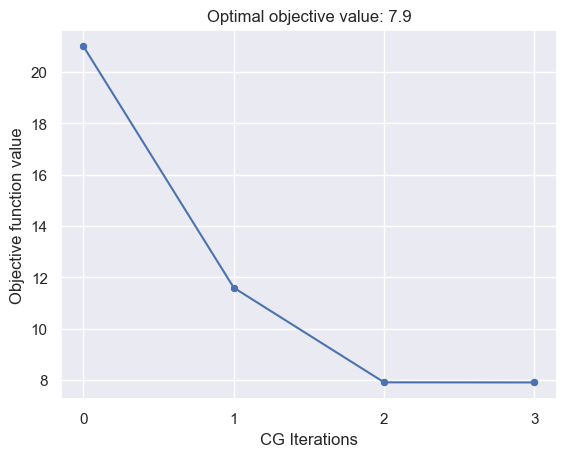

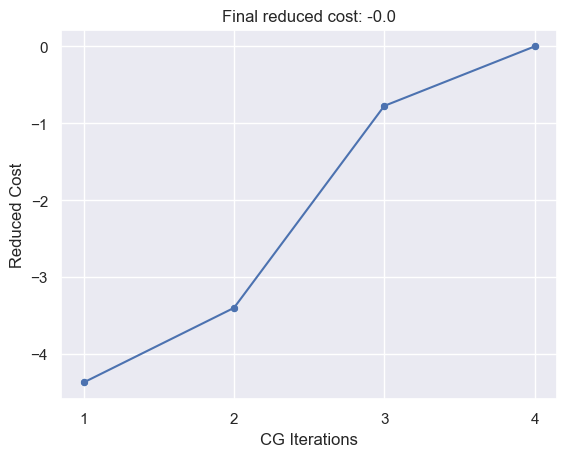

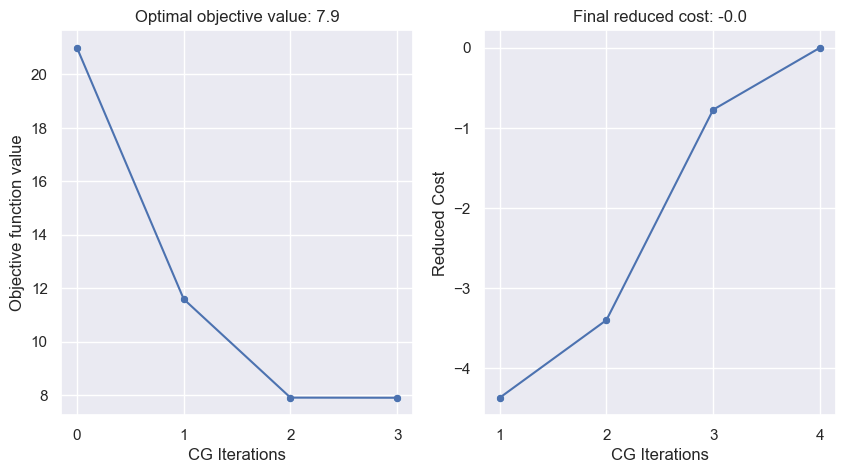

In [100]:
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
from matplotlib.ticker import PercentFormatter, MaxNLocator
import itertools
import os
import matplotlib.pyplot as plt

def plot_obj_val(objValHistRMP):
    sns.set(style='darkgrid')
    sns.scatterplot(x=list(range(len(objValHistRMP))), y=objValHistRMP, marker='o')
    sns.lineplot(x=list(range(len(objValHistRMP))), y=objValHistRMP)
    plt.xlabel('CG Iterations')
    plt.xticks(range(0, len(objValHistRMP)))
    plt.ylabel('Objective function value')
    title = 'Optimal objective value: ' + str(round(objValHistRMP[-1], 4))
    plt.title(title)
    plt.show()

def plot_avg_rc(avg_rc_hist):
    sns.set(style='darkgrid')
    sns.scatterplot(x=list(range(1, len(avg_rc_hist) + 1)), y=avg_rc_hist, marker='o')
    sns.lineplot(x=list(range(1, len(avg_rc_hist) + 1)), y=avg_rc_hist)
    plt.xlabel('CG Iterations')
    plt.xticks(range(1, len(avg_rc_hist)+1))
    plt.ylabel('Reduced Cost')
    title = 'Final reduced cost: ' + str(round(avg_rc_hist[-1], 4))
    plt.title(title)
    plt.show()

def plot_together(objValHistRMP, avg_rc_hist):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    sns.scatterplot(x=list(range(len(objValHistRMP))), y=objValHistRMP, marker='o', ax=axs[0])
    sns.lineplot(x=list(range(len(objValHistRMP))), y=objValHistRMP, ax=axs[0])
    axs[0].set_xlabel('CG Iterations')
    axs[0].set_xticks(range(0, len(objValHistRMP)))
    axs[0].set_ylabel('Objective function value')
    title = 'Optimal objective value: ' + str(round(objValHistRMP[-1], 4))
    axs[0].set_title(title)

    sns.scatterplot(x=list(range(1, len(avg_rc_hist) + 1)), y=avg_rc_hist, marker='o', ax=axs[1])
    sns.lineplot(x=list(range(1, len(avg_rc_hist) + 1)), y=avg_rc_hist, ax=axs[1])
    axs[1].set_xlabel('CG Iterations')
    axs[1].set_xticks(range(1, len(avg_rc_hist)+1))
    axs[1].set_ylabel('Reduced Cost')
    title = 'Final reduced cost: ' + str(round(avg_rc_hist[-1], 4))
    axs[1].set_title(title)

    plt.show()

# Print Plots
plot_obj_val(objValHistRMP)
plot_avg_rc(avg_rc_hist)
plot_together(objValHistRMP, avg_rc_hist)

## 